In [4]:
import pandas as pd
import numpy as np

wdata = open('datasets/web_log_data.csv','r').readlines()

print('\n'.join(wdata[:3]))

ip,date_time,request,step,session,user_id

c210-49-32-6.rochd2.,18/Apr/2005:21:25:07,/,1,3,3

visp.inabox.telstra.,19/Apr/2005:08:24:28,/,1,12,12



In [5]:
# set names of pandas dataframe
names=['Host','Datetime', 'Request', 'Step', 'Session', 'User_ID']
# read the dataframe
df = pd.read_csv('datasets/web_log_data.csv', sep=',', names=names, header=None)

In [6]:
df.head()

,Host,Datetime,Request,Step,Session,User_ID
0,ip,date_time,request,step,session,user_id
1,c210-49-32-6.rochd2.,18/Apr/2005:21:25:07,/,1,3,3
2,visp.inabox.telstra.,19/Apr/2005:08:24:28,/,1,12,12
3,dsl-61-95-54-84.requ,19/Apr/2005:08:33:01,/,1,13,13
4,d220-236-91-52.dsl.n,19/Apr/2005:09:16:06,/,1,15,15


In [7]:
df.drop(0, inplace=True)

df['User_ID'] = df['User_ID'].astype(int)
df['Step'] = df['Step'].astype(int)
df['Session'] = df['Session'].astype(int)

mask = (df['Request'].str.endswith('.css') | df['Request'].str.endswith('.ico') | df['Request'].str.endswith('.js') | df['Request'].str.endswith('.txt'))
print("# Rows before:", len(df))


# invert the mask, only keep records without the wrong extensions in the request column
df2 = df[~mask]

print("After images removal", len(df2))
df2.info()
df2.head()

# Rows before: 5866
After images removal 4458
<class 'pandas.core.frame.DataFrame'>
Int64Index: 4458 entries, 1 to 5866
Data columns (total 6 columns):
Host        4458 non-null object
Datetime    4458 non-null object
Request     4458 non-null object
Step        4458 non-null int32
Session     4458 non-null int32
User_ID     4458 non-null int32
dtypes: int32(3), object(3)
memory usage: 191.6+ KB


,Host,Datetime,Request,Step,Session,User_ID
1,c210-49-32-6.rochd2.,18/Apr/2005:21:25:07,/,1,3,3
2,visp.inabox.telstra.,19/Apr/2005:08:24:28,/,1,12,12
3,dsl-61-95-54-84.requ,19/Apr/2005:08:33:01,/,1,13,13
4,d220-236-91-52.dsl.n,19/Apr/2005:09:16:06,/,1,15,15
5,allptrs.eq.edu.au,19/Apr/2005:09:47:54,/,1,22,22


In [8]:
def clean_column(x):
    result = []
    for i in (x):
        if i[-1:] == '/' and len(i) > 1:
            result.append(i[:-1])
        else:
            result.append(i)
    return result
    
df2['Request'] = clean_column(df2['Request'])
df2['Request'].unique()

df2.info()
df2['Request'].value_counts()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4458 entries, 1 to 5866
Data columns (total 6 columns):
Host        4458 non-null object
Datetime    4458 non-null object
Request     4458 non-null object
Step        4458 non-null int32
Session     4458 non-null int32
User_ID     4458 non-null int32
dtypes: int32(3), object(3)
memory usage: 191.6+ KB


C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


/                                                                821
/eaglefarm                                                       378
/eaglefarm/pricelist                                             376
/eaglefarm/pdf/Web_Price_List.pdf                                296
/services.html                                                   244
/eaglefarm/contact                                               188
/eaglefarm/specials                                              174
/richlands                                                       169
/more.html                                                       145
/richlands/contact                                               126
/direct.html                                                     107
/eaglefarm/fileupload                                             84
/eaglefarm/default.htm                                            81
/index.html                                                       79
/whoare.html                      

In [9]:
df2.head()

,Host,Datetime,Request,Step,Session,User_ID
1,c210-49-32-6.rochd2.,18/Apr/2005:21:25:07,/,1,3,3
2,visp.inabox.telstra.,19/Apr/2005:08:24:28,/,1,12,12
3,dsl-61-95-54-84.requ,19/Apr/2005:08:33:01,/,1,13,13
4,d220-236-91-52.dsl.n,19/Apr/2005:09:16:06,/,1,15,15
5,allptrs.eq.edu.au,19/Apr/2005:09:47:54,/,1,22,22


In [10]:
df3 = df2.sort_values(by=['Step'], ascending=True)

df3.head(20)

,Host,Datetime,Request,Step,Session,User_ID
1,c210-49-32-6.rochd2.,18/Apr/2005:21:25:07,/,1,3,3
1461,lj2271.inktomisearch,21/May/2005:17:37:26,/eaglefarm,1,1471,1471
1456,ctx33.caltex.com.au,19/May/2005:13:27:27,/eaglefarm,1,1361,1361
1452,cpe-61-9-215-107.qld,17/May/2005:11:45:07,/eaglefarm,1,1262,1262
1451,203.84.69.21.in-addr,16/May/2005:19:40:51,/eaglefarm,1,1239,1239
1449,ppp19-249.lns2.syd3.,15/May/2005:22:54:00,/eaglefarm,1,1180,1180
1446,lj2271.inktomisearch,14/May/2005:05:37:23,/eaglefarm,1,1093,1093
1445,cpe-203-45-149-96.ql,12/May/2005:15:29:34,/eaglefarm,1,1026,1026
1444,144.139.173.76,12/May/2005:11:02:34,/eaglefarm,1,1019,1019
1426,lj2271.inktomisearch,06/May/2005:17:17:49,/eaglefarm,1,775,775


In [11]:
transactions = df3.groupby(['User_ID'])['Request'].apply(list)
sequences = transactions.values.tolist()

# show the first 5 sequences
print(sequences[:5])


[['/code/Global/code/menu.html'], ['/', '/services.html', '/more.html', '/guarantee.html'], ['/code/Ultra/services.htm'], ['/richlands', '/richlands', '/richlands/fileupload', '/richlands/fileupload'], ['/richlands/contact', '/richlands/services/printing', '/eaglefarm', '/richlands', '/eaglefarm/specials']]


In [12]:
from collections import defaultdict
import subprocess
import re

''' Uses SPMF to find association rules in supplied transactions '''
def get_association_rules(sequences, min_sup, min_conf):
    # step 1: create required input for SPMF
    
    # prepare a dict to uniquely assign each item in the transactions to an int ID
    item_dict = defaultdict(int)
    output_dict = defaultdict(str)
    item_id = 1
    
    # write your sequences in SPMF format
    with open('seq_rule_input.txt', 'w+') as f:
        for sequence in sequences:
            z = []
            for itemset in sequence:
                # if there are multiple items in one itemset
                if isinstance(itemset, list):
                    for item in itemset:
                        if item not in item_dict:
                            item_dict[item] = item_id
                            item_id += 1

                        z.append(item_dict[item])
                else:
                    if itemset not in item_dict:
                        item_dict[itemset] = item_id
                        output_dict[str(item_id)] = itemset
                        item_id += 1
                    z.append(item_dict[itemset])
                    
                # end of itemset
                z.append(-1)
            
            # end of a sequence
            z.append(-2)
            f.write(' '.join([str(x) for x in z]))
            f.write('\n')
    
    # run SPMF with supplied parameters
    supp_param = '{}%'.format(int(min_sup * 100))
    conf_param = '{}%'.format(int(min_conf * 100))
    subprocess.call(['java', '-jar', 'spmf.jar', 'run', 'RuleGrowth', 'seq_rule_input.txt', 'seq_rule_output.txt', supp_param, conf_param], shell=True)
    
    # read back the output rules
    outputs = open('seq_rule_output.txt', 'r').read().strip().split('\n')
    output_rules = []
    for rule in outputs:
        left, right, sup, conf = re.search(pattern=r'([0-9\,]+) ==> ([0-9\,]+) #SUP: ([0-9]+) #CONF: ([0-9\.]+)', string=rule).groups()
        sup = int(sup) / len(sequences)
        conf = float(conf)
        output_rules.append([[output_dict[x] for x in left.split(',')], [output_dict[x] for x in right.split(',')], sup, conf])
    
    # return pandas DataFrame
    return pd.DataFrame(output_rules, columns = ['Left_rule', 'Right_rule', 'Support', 'Confidence'])

In [13]:
get_association_rules(sequences,0.01,0.01)

,Left_rule,Right_rule,Support,Confidence
0,[/],[/services.html],0.118221,0.267586
1,"[/, /more.html]",[/services.html],0.017063,0.250000
2,[/],"[/services.html, /more.html]",0.054845,0.124138
3,[/],"[/services.html, /more.html, /guarantee.html]",0.016453,0.037241
4,[/],"[/services.html, /more.html, /direct.html]",0.011578,0.026207
5,[/],"[/services.html, /more.html, /index.html]",0.017672,0.040000
6,[/],"[/services.html, /more.html, /whoare.html]",0.015844,0.035862
7,[/],"[/services.html, /guarantee.html]",0.019500,0.044138
8,[/],"[/services.html, /guarantee.html, /whoare.html]",0.010360,0.023448
9,[/],"[/services.html, /direct.html]",0.014625,0.033103


In [14]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4458 entries, 1 to 5866
Data columns (total 6 columns):
Host        4458 non-null object
Datetime    4458 non-null object
Request     4458 non-null object
Step        4458 non-null int32
Session     4458 non-null int32
User_ID     4458 non-null int32
dtypes: int32(3), object(3)
memory usage: 191.6+ KB


In [16]:
df2['Datetime'] = pd.to_datetime(df2['Datetime'], format="%d/%b/%Y:%H:%M:%S")  


df2['day'] = df2['Datetime'].dt.day
df2['month'] = df2['Datetime'].dt.month
df2['hour'] = df2['Datetime'].dt.hour
df2['day_of_week'] = df2['Datetime'].dt.dayofweek
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4458 entries, 1 to 5866
Data columns (total 10 columns):
Host           4458 non-null object
Datetime       4458 non-null datetime64[ns]
Request        4458 non-null object
Step           4458 non-null int32
Session        4458 non-null int32
User_ID        4458 non-null int32
day            4458 non-null int64
month          4458 non-null int64
hour           4458 non-null int64
day_of_week    4458 non-null int64
dtypes: datetime64[ns](1), int32(3), int64(4), object(2)
memory usage: 330.9+ KB


C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is tr

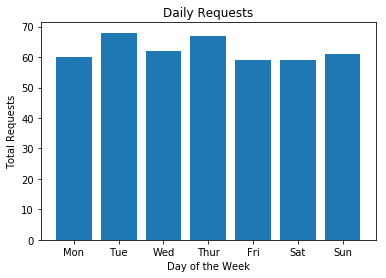

In [21]:
import matplotlib.pyplot as plt

requestDayofWeek = df2.groupby('day_of_week')['Request'].nunique()
requestDayofWeek = pd.DataFrame(requestDayofWeek)
requestDayofWeek.columns= ['NumOfRequests']


day=('Mon', 'Tue', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun')
x_axis=requestDayofWeek.index
plt.bar(x_axis,requestDayofWeek['NumOfRequests'])
plt.xticks(x_axis, day)
plt.ylabel('Total Requests')
plt.xlabel('Day of the Week')
plt.title('Daily Requests')
plt.show()

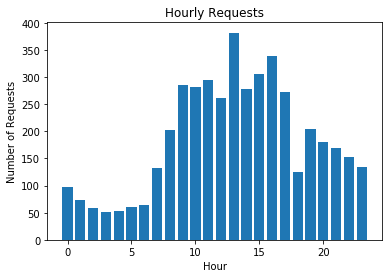

In [23]:
requestPerHour = df2.groupby('hour')['Request'].size()
requestPerHour = pd.DataFrame(data=requestPerHour)
requestPerHour.columns= ['NumOfHourlyRequest']



x_axis=requestPerHour.index
plt.bar(x_axis,requestPerHour['NumOfHourlyRequest'])
plt.ylabel('Number of Requests')
plt.xlabel('Hour')
plt.title('Hourly Requests')
plt.show()

In [25]:
from sklearn.preprocessing import StandardScaler

# take 3 variables and drop the rest
df4 = df2[['User_ID', 'hour', 'day_of_week']]

# convert df2 to matrix
X = df4.as_matrix()

# scaling
scaler = StandardScaler()
X = scaler.fit_transform(X)

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\sklearn\utils\validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [26]:
from sklearn.cluster import KMeans

# random state, we will use 42 instead of 10 for a change
rs = 42

# set the random state. different random state seeds might result in different centroids locations
model = KMeans(n_clusters=3, random_state=rs)
model.fit(X)

# sum of intra-cluster distances
print("Sum of intra-cluster distance:", model.inertia_)

print("Centroid locations:")
for centroid in model.cluster_centers_:
    print(centroid)

Sum of intra-cluster distance: 7773.44133293
Centroid locations:
[-1.12164695  0.01208918  0.11628053]
[ 0.71716168 -0.2633378   0.93279893]
[ 0.49663903  0.20685021 -0.88760808]


In [27]:
# set a different n_clusters
model = KMeans(n_clusters=8, random_state=rs)
model.fit(X)

# sum of intra-cluster distances
print("Sum of intra-cluster distance:", model.inertia_)

print("Centroid locations:")
for centroid in model.cluster_centers_:
    print(centroid)

Sum of intra-cluster distance: 3774.98021645
Centroid locations:
[ 0.42310292  0.59657725 -1.0526559 ]
[-0.8593073   0.30843375  0.86778275]
[-0.7880385  -1.67854281  0.8552343 ]
[ 0.81246296 -0.75236412 -0.47328843]
[-1.10469047  1.12698998 -0.49209678]
[ 0.80325876  0.96636363  0.73757945]
[ 0.98070232 -0.60462757  1.32277239]
[-1.13248889 -0.71848798 -0.8144691 ]


In [28]:
from sklearn.cluster import AgglomerativeClustering

agg_model = AgglomerativeClustering(n_clusters=3)
agg_model.fit(X[:50]) # subset of X, only 50 data points

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward', memory=None, n_clusters=3,
            pooling_func=<function mean at 0x000001D1D72211E0>)

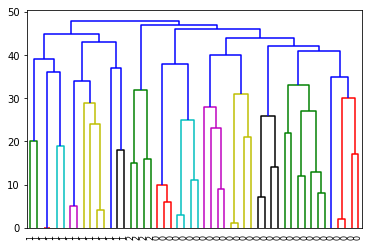

In [29]:
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram

def plot_dendrogram(model, **kwargs):
    # Children of hierarchical clustering
    children = model.children_

    # Distances between each pair of children
    # Since we don't have this information, we can use a uniform one for plotting
    distance = np.arange(children.shape[0])

    # The number of observations contained in each cluster level
    no_of_observations = np.arange(2, children.shape[0]+2)

    # Create linkage matrix and then plot the dendrogram
    linkage_matrix = np.column_stack([children, distance, no_of_observations]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)
    
plot_dendrogram(agg_model, labels=agg_model.labels_)
plt.show()

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Cluster membership
2    1590
0    1548
1    1320
Name: Cluster_ID, dtype: int64


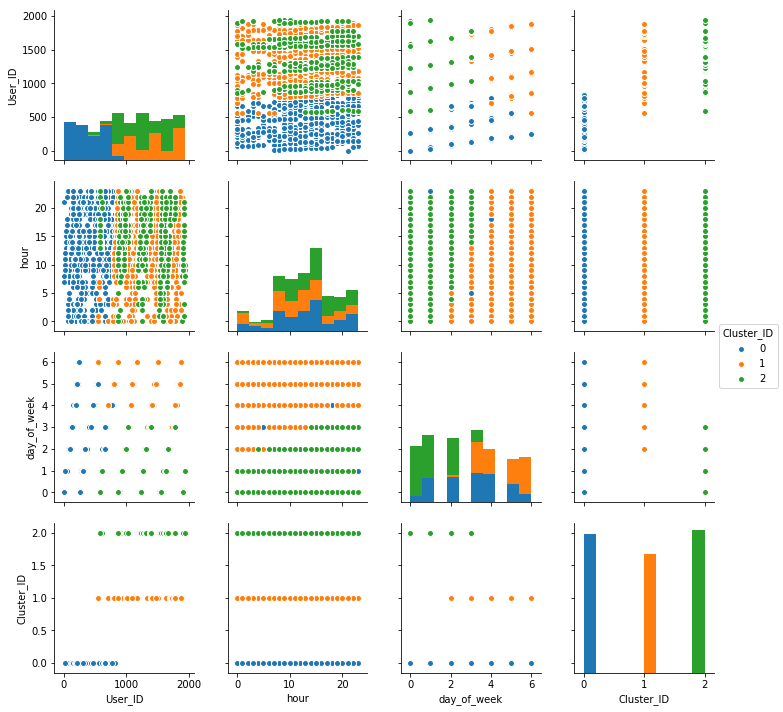

In [31]:
import seaborn as sns

model = KMeans(n_clusters=3, random_state=rs).fit(X)

# assign cluster ID to each record in X
# Ignore the warning, does not apply to our case here
y = model.predict(X)
df4['Cluster_ID'] = y

# how many records are in each cluster
print("Cluster membership")
print(df4['Cluster_ID'].value_counts())

# pairplot the cluster distribution.
cluster_g = sns.pairplot(df4, hue='Cluster_ID')
plt.show()